In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
os.chdir('/Users/stevengeorge/Documents/Github/fpl-analysis/')

from src.models.constants import STATIC_FEATURES, TIME_SERIES_FEATURES
from src.data.live_season_data import GetFPLData
from src.features.custom_transformers import TimeSeriesFeatures

pd.set_option('display.max_columns', None)

DATA_PATH = 'data/processed/'

### Historical data

In [4]:
fpl_data_all_seasons = pd.read_parquet(DATA_PATH + 'fpl_data_2016_to_2019.parquet')
print(fpl_data_all_seasons.shape)
fpl_data_all_seasons.head()

(67986, 73)


,name,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,dribbles,ea_index,errors_leading_to_goal,errors_leading_to_goal_attempt,fouls,goals_conceded,goals_scored,ict_index,influence,key_passes,loaned_in,loaned_out,minutes,offside,open_play_crosses,own_goals,penalties_conceded,penalties_missed,penalties_saved,recoveries,red_cards,saves,selected,tackled,tackles,target_missed,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Aug,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,14023,0,0,0,1,2,0.0,0,0,0,0,5.5,False,0,0,1,2016-17,West Ham United,0,0,1,0,0,0,Chelsea,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,11531,0,0,0,0,1,0.0,0,-3002,79,3081,5.5,True,0,0,2,2016-17,West Ham United,0,0,1,0,0,0,Bournemouth,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,9587,0,0,0,1,3,0.0,0,-2053,28,2081,5.4,False,0,0,3,2016-17,West Ham United,0,0,1,0,0,0,Manchester City,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,8427,0,0,0,4,2,0.0,0,-1221,45,1266,5.4,True,0,0,4,2016-17,West Ham United,0,0,1,0,0,0,Watford,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,aaron_cresswell,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,7933,0,0,0,2,4,0.0,0,-520,29,549,5.4,False,0,0,5,2016-17,West Ham United,0,0,1,0,0,0,West Bromwich Albion,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [5]:
# Columns used to train GW2 model
AVAILABLE_COLUMNS = [
    'name', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
    'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'gw', 'season', 'team_name',
    'promoted_side', 'top_6_last_season', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'team_name_opponent', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Aug',
    'late_kickoff', 'early_kickoff', 'ID', 'kickoff_month_Apr', 'kickoff_month_Dec', 'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct',
    'kickoff_month_Sep'
]

In [6]:
fpl_data_all_seasons = fpl_data_all_seasons[AVAILABLE_COLUMNS]
fpl_data_all_seasons.shape

(67986, 52)

### Current season previous GW data

In [7]:
current_gw_data = pd.read_parquet('data/gw_player_data/gw_6_player_data.parquet')
print(current_gw_data.shape)
current_gw_data.head()

(3196, 44)


,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,kickoff_month_Sep,late_kickoff,early_kickoff,ID
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,33117,1,0,0.0,0,0,0,0,5.5,False,0,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Newcastle United,0,0,1,0,0,0,484
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,36709,1,2,0.0,0,-5280,2868,8148,5.5,True,0,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Burnley,0,0,1,0,0,1,484
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,30975,1,3,0.0,0,-6882,534,7416,5.4,False,0,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Liverpool,0,1,1,0,1,0,484
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,28096,2,2,0.0,0,-3872,346,4218,5.4,True,0,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Tottenham Hotspur,0,1,0,1,0,0,484
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,26902,2,2,0.0,0,-2073,581,2654,5.3,False,0,shkodran_mustafi,Arsenal,0,1,2019-20,1,0,0,0,Watford,0,0,0,1,0,0,484


In [8]:
set(AVAILABLE_COLUMNS) - set(current_gw_data.columns)

{'kickoff_month_Apr',
 'kickoff_month_Dec',
 'kickoff_month_Feb',
 'kickoff_month_Jan',
 'kickoff_month_Mar',
 'kickoff_month_May',
 'kickoff_month_Nov',
 'kickoff_month_Oct'}

In [9]:
for col in list(set(AVAILABLE_COLUMNS) - set(current_gw_data.columns)):
    current_gw_data[col] = 0

In [10]:
set(AVAILABLE_COLUMNS) - set(current_gw_data.columns)

set()

In [11]:
current_gw_data.shape

(3196, 52)

### Future fixture data

In [12]:
get_fpl_data = GetFPLData('2019-20')

In [13]:
upcoming_fixtures = get_fpl_data.get_all_fixture_data_from_api()

2019-09-27 00:18:54,951 - Completed 10/541
2019-09-27 00:18:55,820 - Completed 20/541
2019-09-27 00:18:56,733 - Completed 30/541
2019-09-27 00:18:57,664 - Completed 40/541
2019-09-27 00:18:58,545 - Completed 50/541
2019-09-27 00:18:59,424 - Completed 60/541
2019-09-27 00:19:00,395 - Completed 70/541
2019-09-27 00:19:01,305 - Completed 80/541
2019-09-27 00:19:02,206 - Completed 90/541
2019-09-27 00:19:03,122 - Completed 100/541
2019-09-27 00:19:04,048 - Completed 110/541
2019-09-27 00:19:05,042 - Completed 120/541
2019-09-27 00:19:05,970 - Completed 130/541
2019-09-27 00:19:06,956 - Completed 140/541
2019-09-27 00:19:07,934 - Completed 150/541
2019-09-27 00:19:08,880 - Completed 160/541
2019-09-27 00:19:09,817 - Completed 170/541
2019-09-27 00:19:10,768 - Completed 180/541
2019-09-27 00:19:11,738 - Completed 190/541
2019-09-27 00:19:12,688 - Completed 200/541
2019-09-27 00:19:13,655 - Completed 210/541
2019-09-27 00:19:14,689 - Completed 220/541
2019-09-27 00:19:15,625 - Completed 230/5

In [14]:
print(upcoming_fixtures.shape)
upcoming_fixtures.head()

(17312, 42)


,code,difficulty,gw,event_name,finished,was_home,kickoff_time,minutes,provisional_start_time,team_a,team_a_score,team_h,team_h_score,name,id,team_name,promoted_side,top_6_last_season,season,value,chance_of_playing_next_round,chance_of_playing_this_round,opponent_team,team_name_opponent,team,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,late_kickoff,early_kickoff,position_DEF,position_FWD,position_GK,position_MID
0,1059768,4,7,Gameweek 7,False,False,2019-09-30 20:00:00+01:00,0,False,1,None,12,None,shkodran_mustafi,1,Arsenal,0,1,2019-20,5.3,NaN,NaN,12.0,Manchester United,12,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0
1,1059772,2,8,Gameweek 8,False,True,2019-10-06 14:00:00+01:00,0,False,3,None,1,None,shkodran_mustafi,1,Arsenal,0,1,2019-20,5.3,NaN,NaN,3.0,Bournemouth,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,1059789,2,9,Gameweek 9,False,False,2019-10-21 20:00:00+01:00,0,False,1,None,15,None,shkodran_mustafi,1,Arsenal,0,1,2019-20,5.3,NaN,NaN,15.0,Sheffield Utd,15,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0
3,1059792,2,10,Gameweek 10,False,True,2019-10-27 16:30:00+00:00,0,False,7,None,1,None,shkodran_mustafi,1,Arsenal,0,1,2019-20,5.3,NaN,NaN,7.0,Crystal Palace,7,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,1059803,2,11,Gameweek 11,False,True,2019-11-02 15:00:00+00:00,0,False,20,None,1,None,shkodran_mustafi,1,Arsenal,0,1,2019-20,5.3,NaN,NaN,20.0,Wolverhampton Wanderers,20,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [15]:
upcoming_gw_7_features = upcoming_fixtures.copy()
upcoming_gw_7_features = upcoming_gw_7_features[upcoming_gw_7_features['gw'] == 7]

### Combine historical, current known season data and future fixture data

In [16]:
set(fpl_data_all_seasons.columns) - set(current_gw_data.columns)

set()

In [17]:
fpl_data_all_seasons_with_current = fpl_data_all_seasons.append(current_gw_data, sort=False)
fpl_data_all_seasons_with_current.shape

(71182, 52)

In [18]:
static_columns = list(set(fpl_data_all_seasons_with_current.columns).intersection(set(upcoming_gw_7_features.columns)))

In [19]:
upcoming_gw_7_features = upcoming_gw_7_features[static_columns]
upcoming_gw_7_features.shape

(541, 29)

In [20]:
upcoming_gw_7_features.head()

,position_DEF,late_kickoff,season,position_MID,team_a_score,kickoff_month_Mar,top_6_last_season,kickoff_month_Apr,position_FWD,was_home,top_6_last_season_opponent,promoted_side,position_GK,kickoff_month_Oct,team_name,team_name_opponent,promoted_side_opponent,minutes,kickoff_month_May,name,value,kickoff_month_Dec,early_kickoff,kickoff_month_Nov,kickoff_month_Feb,gw,kickoff_month_Sep,kickoff_month_Jan,team_h_score
0,1,1,2019-20,0,None,0,1,0,0,False,1,0,0,0,Arsenal,Manchester United,0,0,0,shkodran_mustafi,5.3,0,0,0,0,7,1,0,None
32,1,1,2019-20,0,None,0,1,0,0,False,1,0,0,0,Arsenal,Manchester United,0,0,0,héctor_bellerín,5.4,0,0,0,0,7,1,0,None
64,1,1,2019-20,0,None,0,1,0,0,False,1,0,0,0,Arsenal,Manchester United,0,0,0,sead_kolasinac,5.4,0,0,0,0,7,1,0,None
96,1,1,2019-20,0,None,0,1,0,0,False,1,0,0,0,Arsenal,Manchester United,0,0,0,ainsley_maitland-niles,5.1,0,0,0,0,7,1,0,None
128,1,1,2019-20,0,None,0,1,0,0,False,1,0,0,0,Arsenal,Manchester United,0,0,0,sokratis_papastathopoulos,5.0,0,0,0,0,7,1,0,None


In [21]:
upcoming_gw_7_features.drop('minutes', inplace=True, axis=1)  # This is total minutes played so far in season

In [22]:
fpl_data_all_seasons_with_current_and_future = fpl_data_all_seasons_with_current.append(upcoming_gw_7_features, sort=False)
fpl_data_all_seasons_with_current_and_future.shape

(71723, 52)

In [23]:
fpl_data_all_seasons_with_current_and_future['season_order'] = fpl_data_all_seasons_with_current_and_future['season'].map({
    '2016-17': 1,
    '2017-18': 2,
    '2018-19': 3,
    '2019-20': 4
})

In [24]:
fpl_data_all_seasons_with_current_and_future.sort_values(['name', 'season_order', 'gw'], inplace=True)
fpl_data_all_seasons_with_current_and_future.reset_index(drop=True, inplace=True)

__Shift forward static features e.g. next opponent etc.__

In [25]:
for feature in ['value', 'was_home', 'promoted_side_opponent', 'top_6_last_season_opponent', 'kickoff_month_Apr', 'kickoff_month_Aug', 'kickoff_month_Dec',
                'kickoff_month_Feb', 'kickoff_month_Jan', 'kickoff_month_Mar', 'kickoff_month_May', 'kickoff_month_Nov', 'kickoff_month_Oct', 
                'kickoff_month_Sep', 'late_kickoff', 'early_kickoff']:
    fpl_data_all_seasons_with_current_and_future[f'next_match_{feature}'] = fpl_data_all_seasons_with_current_and_future.groupby('name')[f'{feature}'].shift(-1)

### Create time series features

Create new ID

In [26]:
fpl_data_all_seasons_with_current_and_future.drop('ID', axis=1, inplace=True)

In [27]:
id_df = fpl_data_all_seasons_with_current_and_future.groupby(['name']).count().reset_index()[['name']]
id_df['ID'] = id_df.index + 1
print(id_df.shape)
id_df.head()

(1208, 2)


,name,ID
0,aaron_connolly,1
1,aaron_cresswell,2
2,aaron_lennon,3
3,aaron_mooy,4
4,aaron_ramsdale,5


In [28]:
fpl_data_all_seasons_with_current_and_future = fpl_data_all_seasons_with_current_and_future.merge(id_df, how='left', on=['name'])

In [29]:
TIME_SERIES_FEATURES_LITE = list(set(AVAILABLE_COLUMNS).intersection(TIME_SERIES_FEATURES))

In [30]:
ts_features = TimeSeriesFeatures(halflife=4, max_lag=4, max_diff=4, columns=TIME_SERIES_FEATURES_LITE)

In [31]:
fpl_data_all_seasons_with_current_and_future[TIME_SERIES_FEATURES_LITE].info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71723 entries, 0 to 71722
Data columns (total 25 columns):
transfers_out        71182 non-null float64
influence            71182 non-null object
creativity           71182 non-null object
penalties_saved      71182 non-null float64
team_a_score         71182 non-null object
goals_scored         71182 non-null float64
threat               71182 non-null object
total_points         71182 non-null float64
bonus                71182 non-null float64
red_cards            71182 non-null float64
assists              71182 non-null float64
ict_index            71182 non-null object
own_goals            71182 non-null float64
selected             71182 non-null float64
transfers_balance    71182 non-null float64
goals_conceded       71182 non-null float64
clean_sheets         71182 non-null float64
minutes              71182 non-null float64
bps                  71182 non-null float64
penalties_missed     71182 non-null float64
value           

In [32]:
for col in TIME_SERIES_FEATURES_LITE:
    fpl_data_all_seasons_with_current_and_future[col] = pd.to_numeric(fpl_data_all_seasons_with_current_and_future[col])

In [33]:
%%time
fpl_data_all_seasons_with_ts = ts_features.fit_transform(fpl_data_all_seasons_with_current_and_future)
print(fpl_data_all_seasons_with_ts.shape)

(71723, 294)
CPU times: user 1min 56s, sys: 44.4 s, total: 2min 40s
Wall time: 1min 53s


In [34]:
fpl_data_all_seasons_with_ts.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,minutes_EMA,minutes_L1,minutes_L2,minutes_L3,minutes_L4,minutes_D1,minutes_D2,minutes_D3,minutes_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yell

### Make predictions

### 1. Who will play more than 60 mins?

In [35]:
#data_for_prediction = fpl_data_all_seasons_with_ts.copy()[
#    (fpl_data_all_seasons_with_ts['season_order'] == 4) & (fpl_data_all_seasons_with_ts['gw'] == 3)
#]
#data_for_prediction.head()

In [36]:
#data_for_prediction['next_match_was_home'] = data_for_prediction['next_match_was_home'].astype(bool)

In [37]:
#data_for_prediction['played'] = np.where(
#    data_for_prediction['minutes'] <= 60,
#    0,
#    1
#)

In [38]:
# Load model
#less60_classifier = pickle.load(open('src/models/pickles/v2_1_lgbm_less60_classifier.pickle', 'rb'))

In [39]:
#predictions = less60_classifier.predict(
#    data_for_prediction.drop(
#        ['name', 'season', 'team_name', 'team_name_opponent', 'ID'],
#        axis=1
#    )
#)

In [40]:
#data_for_prediction['play_more_than_60'] = predictions

In [41]:
#data_for_score_prediction = data_for_prediction.copy()[data_for_prediction['play_more_than_60'] == 1]
#data_for_score_prediction.shape

In [42]:
#data_for_score_prediction.head()

For some reason model isn't working...need to investigate!

## For now use baseline prediction

In [43]:
data_for_prediction = fpl_data_all_seasons_with_ts.copy()[
    (fpl_data_all_seasons_with_ts['season_order'] == 4) & (fpl_data_all_seasons_with_ts['gw'] == 6)
]
print(data_for_prediction.shape)
data_for_prediction.head()

(541, 294)


,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,minutes_EMA,minutes_L1,minutes_L2,minutes_L3,minutes_L4,minutes_D1,minutes_D2,minutes_D3,minutes_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yell

In [44]:
data_for_prediction['played'] = np.where(
    data_for_prediction['minutes'] <= 60,
    0,
    1
)

In [45]:
data_for_prediction['baseline_prediction'] = np.where(
    data_for_prediction['played']==0,
    0,
    1
)

### Need to keep players in current team

In [46]:
gw6_team_selection = pd.read_parquet('data/gw_team_selections/gw6_v2_1_team_selections.parquet')
gw6_team_selection['in_current_team'] = 1
gw6_team_selection

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,next_match_value,in_gw_1_team,team_name_Arsenal,team_name_Aston Villa,team_name_Bournemouth,team_name_Brighton & Hove Albion,team_name_Burnley,team_name_Chelsea,team_name_Crystal Palace,team_name_Everton,team_name_Leicester City,team_name_Liverpool,team_name_Manchester City,team_name_Manchester United,team_name_Newcastle United,team_name_Norwich,team_name_Sheffield Utd,team_name_Southampton,team_name_Tottenham Hotspur,team_name_Watford,team_name_West Ham United,team_name_Wolverhampton Wanderers,starting_11,in_current_team
0,emiliano_buendía,0,0,0,1,7.236745,6.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.0,1
1,joshua_king,0,1,0,0,6.964995,6.3,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1
2,callum_wilson,0,1,0,0,6.823344,7.8,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1
3,hugo_lloris,0,0,1,0,6.509238,5.5,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.0,1
4,david_silva,0,0,0,1,6.495237,7.5,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.0,1
5,patrick_van_aanholt,1,0,0,0,6.451569,5.5,1.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1
6,ashley_young,1,0,0,0,6.392363,5.4,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,1
7,ashley_barnes,0,1,0,0,5.874045,6.6,1.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1
8,mohamed_salah,0,0,0,1,5.677532,12.5,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,1
9,joel_matip,1,0,0,0,5.157824,5.5,1.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,1


In [47]:
# Format name to allign with usage in team selection:
data_for_prediction['name'] = data_for_prediction['name'].str.replace(' ', '_')
data_for_prediction['name'] = data_for_prediction['name'].str.replace('-', '_')

In [48]:
data_for_prediction = data_for_prediction.merge(
    gw6_team_selection[['name', 'in_current_team']],
    how='left',
    on='name'
)
data_for_prediction['in_current_team'].fillna(0, inplace=True)

In [49]:
# If in current team set baseline prediction to 1 i.e. must include in data for prediction if they are already in the team
data_for_prediction['baseline_prediction'] = np.where(
    data_for_prediction['in_current_team'] == 1,
    1,
    data_for_prediction['baseline_prediction']
)

In [50]:
data_for_prediction = data_for_prediction[data_for_prediction['baseline_prediction'] == 1]
data_for_prediction.shape

(209, 297)

In [51]:
data_for_prediction['next_match_was_home'] = data_for_prediction['next_match_was_home'].astype(bool)

In [52]:
data_for_prediction.head()

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,minutes_EMA,minutes_L1,minutes_L2,minutes_L3,minutes_L4,minutes_D1,minutes_D2,minutes_D3,minutes_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yell

In [53]:
data_for_prediction.drop(columns='in_current_team', axis=1, inplace=True)

In [54]:
%%capture
# Load model
lgbm_point_predictor = pickle.load(open('src/models/pickles/v2_1_lgbm_point_predictor.pickle', 'rb'))

In [55]:
predictions = lgbm_point_predictor.predict(
    data_for_prediction.drop(
        ['name', 'season', 'team_name', 'team_name_opponent', 'ID', 'baseline_prediction'],
        axis=1
    )
)

In [56]:
data_for_prediction['predictions'] = predictions

In [57]:
data_for_prediction.sort_values('predictions', ascending=False).head(10)

,name,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,season,team_name,promoted_side,top_6_last_season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,kickoff_month_Aug,late_kickoff,early_kickoff,kickoff_month_Apr,kickoff_month_Dec,kickoff_month_Feb,kickoff_month_Jan,kickoff_month_Mar,kickoff_month_May,kickoff_month_Nov,kickoff_month_Oct,kickoff_month_Sep,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Apr,next_match_kickoff_month_Aug,next_match_kickoff_month_Dec,next_match_kickoff_month_Feb,next_match_kickoff_month_Jan,next_match_kickoff_month_Mar,next_match_kickoff_month_May,next_match_kickoff_month_Nov,next_match_kickoff_month_Oct,next_match_kickoff_month_Sep,next_match_late_kickoff,next_match_early_kickoff,ID,transfers_out_EMA,transfers_out_L1,transfers_out_L2,transfers_out_L3,transfers_out_L4,transfers_out_D1,transfers_out_D2,transfers_out_D3,transfers_out_D4,influence_EMA,influence_L1,influence_L2,influence_L3,influence_L4,influence_D1,influence_D2,influence_D3,influence_D4,creativity_EMA,creativity_L1,creativity_L2,creativity_L3,creativity_L4,creativity_D1,creativity_D2,creativity_D3,creativity_D4,penalties_saved_EMA,penalties_saved_L1,penalties_saved_L2,penalties_saved_L3,penalties_saved_L4,penalties_saved_D1,penalties_saved_D2,penalties_saved_D3,penalties_saved_D4,team_a_score_EMA,team_a_score_L1,team_a_score_L2,team_a_score_L3,team_a_score_L4,team_a_score_D1,team_a_score_D2,team_a_score_D3,team_a_score_D4,goals_scored_EMA,goals_scored_L1,goals_scored_L2,goals_scored_L3,goals_scored_L4,goals_scored_D1,goals_scored_D2,goals_scored_D3,goals_scored_D4,threat_EMA,threat_L1,threat_L2,threat_L3,threat_L4,threat_D1,threat_D2,threat_D3,threat_D4,total_points_EMA,total_points_L1,total_points_L2,total_points_L3,total_points_L4,total_points_D1,total_points_D2,total_points_D3,total_points_D4,bonus_EMA,bonus_L1,bonus_L2,bonus_L3,bonus_L4,bonus_D1,bonus_D2,bonus_D3,bonus_D4,red_cards_EMA,red_cards_L1,red_cards_L2,red_cards_L3,red_cards_L4,red_cards_D1,red_cards_D2,red_cards_D3,red_cards_D4,assists_EMA,assists_L1,assists_L2,assists_L3,assists_L4,assists_D1,assists_D2,assists_D3,assists_D4,ict_index_EMA,ict_index_L1,ict_index_L2,ict_index_L3,ict_index_L4,ict_index_D1,ict_index_D2,ict_index_D3,ict_index_D4,own_goals_EMA,own_goals_L1,own_goals_L2,own_goals_L3,own_goals_L4,own_goals_D1,own_goals_D2,own_goals_D3,own_goals_D4,selected_EMA,selected_L1,selected_L2,selected_L3,selected_L4,selected_D1,selected_D2,selected_D3,selected_D4,transfers_balance_EMA,transfers_balance_L1,transfers_balance_L2,transfers_balance_L3,transfers_balance_L4,transfers_balance_D1,transfers_balance_D2,transfers_balance_D3,transfers_balance_D4,goals_conceded_EMA,goals_conceded_L1,goals_conceded_L2,goals_conceded_L3,goals_conceded_L4,goals_conceded_D1,goals_conceded_D2,goals_conceded_D3,goals_conceded_D4,clean_sheets_EMA,clean_sheets_L1,clean_sheets_L2,clean_sheets_L3,clean_sheets_L4,clean_sheets_D1,clean_sheets_D2,clean_sheets_D3,clean_sheets_D4,minutes_EMA,minutes_L1,minutes_L2,minutes_L3,minutes_L4,minutes_D1,minutes_D2,minutes_D3,minutes_D4,bps_EMA,bps_L1,bps_L2,bps_L3,bps_L4,bps_D1,bps_D2,bps_D3,bps_D4,penalties_missed_EMA,penalties_missed_L1,penalties_missed_L2,penalties_missed_L3,penalties_missed_L4,penalties_missed_D1,penalties_missed_D2,penalties_missed_D3,penalties_missed_D4,value_EMA,value_L1,value_L2,value_L3,value_L4,value_D1,value_D2,value_D3,value_D4,saves_EMA,saves_L1,saves_L2,saves_L3,saves_L4,saves_D1,saves_D2,saves_D3,saves_D4,yellow_cards_EMA,yellow_cards_L1,yellow_cards_L2,yellow_cards_L3,yellow_cards_L4,yellow_cards_D1,yellow_cards_D2,yell

In [58]:
predictions_output = data_for_prediction.copy()
predictions_output.sort_values('predictions', ascending=False, inplace=True)
predictions_output = predictions_output[['name', 'position_DEF', 'position_FWD', 'position_GK', 'position_MID', 'predictions', 'team_name', 'next_match_value']]
predictions_output.head()

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value
207,heung_min_son,0,0,0,1,6.260830,Tottenham Hotspur,9.7
479,sergio_agüero,0,1,0,0,6.239965,Manchester City,12.2
243,jamie_vardy,0,1,0,0,6.183422,Leicester City,8.9
200,harry_kane,0,1,0,0,6.108600,Tottenham Hotspur,11.0
165,erik_lamela,0,0,0,1,5.991544,Tottenham Hotspur,6.1


In [59]:
predictions_output.tail()

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value
464,ryan_fredericks,1,0,0,0,2.648906,West Ham United,4.5
354,martín_montoya,1,0,0,0,2.529541,Brighton & Hove Albion,4.5
94,chris_basham,1,0,0,0,2.517391,Sheffield Utd,4.5
64,ben_godfrey,1,0,0,0,2.489340,Norwich,4.5
263,john_egan,1,0,0,0,2.188153,Sheffield Utd,4.5


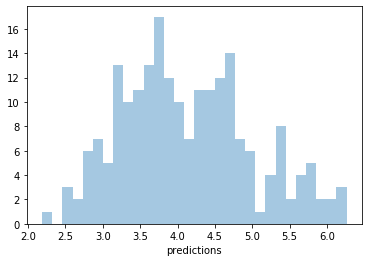

In [60]:
sns.distplot(predictions_output['predictions'], kde=False, bins=30)

In [61]:
predictions_output.to_parquet('data/gw_predictions/gw7_v2.1_player_predictions.parquet', index=False)

In [62]:
predictions_output.head(20)

,name,position_DEF,position_FWD,position_GK,position_MID,predictions,team_name,next_match_value
207,heung_min_son,0,0,0,1,6.260830,Tottenham Hotspur,9.7
479,sergio_agüero,0,1,0,0,6.239965,Manchester City,12.2
243,jamie_vardy,0,1,0,0,6.183422,Leicester City,8.9
200,harry_kane,0,1,0,0,6.108600,Tottenham Hotspur,11.0
165,erik_lamela,0,0,0,1,5.991544,Tottenham Hotspur,6.1
451,roberto_firmino,0,1,0,0,5.931454,Liverpool,9.5
282,joshua_king,0,1,0,0,5.909114,Bournemouth,6.3
443,ricardo_domingos_barbosa_pereira,1,0,0,0,5.843810,Leicester City,6.0
146,diogo_jota,0,1,0,0,5.816948,Wolverhampton Wanderers,6.2
113,césar_azpilicueta,1,0,0,0,5.812074,Chelsea,5.9


## THERE IS A BIG BUG IN MODEL WHICH IS CAUSING PREDICTIONS TO BE DIFFERENT ON DIFFERENT RUNS - NEED TO INVESTIGATE!